In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)

In [2]:
data_root = "/scratch/shared/beegfs/piyush/datasets/AoTBench"
meta_dir = f"{data_root}/AoTBench/data_files"
video_dir = f"{data_root}/videos"

!ls $meta_dir
# !ls $video_dir

AoTBench_QA.json  ReverseFilm.json  Rtime_t2v.json  Rtime_v2t.json  UCF101.json


In [3]:
data = su.io.load_json(f"{meta_dir}/ReverseFilm.json") + su.io.load_json(f"{meta_dir}/UCF101.json")
len(data)

644

In [4]:
from models.modeling_encoders import AutoEncoder

model_id = '/work/piyush/pretrained_checkpoints/Tarsier-7b'
# model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint"
# model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/"\
#     "nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint"
encoder = AutoEncoder.from_pretrained(model_id, device_map='cuda:0')
su.misc.num_params(encoder.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/Tarsier-7b
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


In [7]:
def generate_answer(prompt, pixel_values, max_new_tokens=2048):

    pixel_values = transform_pixel_values(pixel_values) # [B, T, C, H, W]
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)
    descriptions = []
    generate_kwargs = {
        "do_sample": False,
        "max_new_tokens": max_new_tokens,
        "top_p": 1,
        "temperature": 0,
        "use_cache": True
    }

    for frames in batched_frames:
        text_inputs = f"<video>\n{prompt}"
        text_inputs = encoder.processor.process_prompt(text_inputs, frames)
        text_inputs = encoder.processor.get_text_inputs(text_inputs)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": text_inputs,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        output_text = encoder.processor.tokenizer.decode(
            outputs[0][inputs['input_ids'][0].shape[0]:],
            skip_special_tokens=True,
        )
        descriptions.append(output_text)
    return descriptions

video_path = '../../TimeBound.v1/sample_data/folding_paper.mp4'
video_tensor = read_frames_decord(video_path, num_frames=8)
with torch.no_grad():
    answer = generate_answer(
        "What is happening in this video? Answer in short.",
        video_tensor.unsqueeze(0),
        max_new_tokens=256,
    )
print(answer)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


['A hand folds a white paper into a triangle.']


In [8]:
# with torch.no_grad():
#     answer = generate_answer(
#         data[0]['question'],
#         video_tensor.unsqueeze(0),
#         max_new_tokens=256,
#     )
# print(answer)

**Generate answers for each sample**

In [9]:
iterator = su.log.tqdm_iterator(range(len(data)), desc='Generating answers')
answers = []
for i in iterator:
    d = data[i]
    video_path = f"{data_root}/{d['video_name']}"
    video_tensor = read_frames_decord(video_path, num_frames=8)
    with torch.no_grad():
        answer = generate_answer(
            d['question'],
            video_tensor.unsqueeze(0),
            max_new_tokens=256,
        )
    answers.append(answer)
len(answers)

Generating answers:   0%|          | 0/644 [00:00<?, ?it/s]

644

In [10]:
type(answers[0])

list

In [11]:
ground_truth = np.array([d['ans'] for d in data])
ground_truth.shape

(644,)

In [12]:
(np.array(answers)[:, 0] == ground_truth).mean()

np.float64(0.5124223602484472)

In [13]:
ground_truth[:10]

array(['B', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'A'], dtype='<U1')

In [14]:
np.array(answers)[:, 0][:10]

array(['B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A'], dtype='<U1')

In [15]:
video_dir

'/scratch/shared/beegfs/piyush/datasets/AoTBench/videos'

In [16]:
# video_path_forward = f"{video_dir}/UCF101/v_FrontCrawl_g07_c01-00763-forward.mp4"
# video_path_reverse = f"{video_dir}/UCF101/v_FrontCrawl_g07_c01-00763-reverse.mp4"

# video_path_forward = f"{video_dir}/UCF101/v_MilitaryParade_g02_c01-00828-forward.mp4"
# video_path_reverse = f"{video_dir}/UCF101/v_MilitaryParade_g02_c01-00828-reverse.mp4"

# video_path_forward = f"{video_dir}/UCF101/v_BaseballPitch_g02_c02-00345-forward.mp4"
# video_path_reverse = f"{video_dir}/UCF101/v_BaseballPitch_g02_c02-00345-reverse.mp4"

video_path_forward = np.random.choice(glob(f"{video_dir}/UCF101/*-forward.mp4"))
video_path_reverse = video_path_forward.replace('forward', 'reverse')

assert os.path.exists(video_path_forward)
assert os.path.exists(video_path_reverse)

display(su.visualize.show_single_video(video_path_forward))
display(su.visualize.show_single_video(video_path_reverse))

In [17]:
video_tensor_forward = read_frames_decord(video_path_forward, num_frames=8)
video_tensor_reverse = read_frames_decord(video_path_reverse, num_frames=8)
with torch.no_grad():
    answer_forward = generate_answer(
        "What is happening in this video? Look carefully and answer in short.",
        video_tensor_forward.unsqueeze(0),
        max_new_tokens=256,
    )
    answer_reverse = generate_answer(
        "What is happening in this video? Look carefully and answer in short.",
        video_tensor_reverse.unsqueeze(0),
        max_new_tokens=256,
    )
print(answer_forward)
print(answer_reverse)

['Baseball player pitches ball, other player runs towards pitcher.']
["Baseball pitcher throws a pitch, camera follows pitcher's motion."]


**For a particular class, visualise tSNE features.**

In [18]:
classes = np.unique(['_'.join(x.split('/')[-1].split("_")[:2]) for x in glob(f"{video_dir}/UCF101/*-forward.mp4")])
classes

array(['v_Archery', 'v_BabyCrawling', 'v_BalanceBeam', 'v_BandMarching',
       'v_BaseballPitch', 'v_Basketball', 'v_BasketballDunk', 'v_Biking',
       'v_Billiards', 'v_BlowingCandles', 'v_Bowling', 'v_BreastStroke',
       'v_CliffDiving', 'v_CricketBowling', 'v_CricketShot',
       'v_CuttingInKitchen', 'v_Diving', 'v_FieldHockeyPenalty',
       'v_FloorGymnastics', 'v_FrisbeeCatch', 'v_FrontCrawl',
       'v_GolfSwing', 'v_HammerThrow', 'v_HandstandWalking', 'v_HighJump',
       'v_HorseRace', 'v_JavelinThrow', 'v_Kayaking', 'v_LongJump',
       'v_MilitaryParade', 'v_ParallelBars', 'v_PoleVault', 'v_Rafting',
       'v_RopeClimbing', 'v_Shotput', 'v_Skiing', 'v_Skijet',
       'v_SoccerPenalty', 'v_StillRings', 'v_Surfing', 'v_TennisSwing',
       'v_ThrowDiscus', 'v_UnevenBars', 'v_VolleyballSpiking',
       'v_WalkingWithDog', 'v_WritingOnBoard'], dtype='<U20')

In [19]:
class_name = np.random.choice(classes)
fwd_files = sorted(glob(f"{video_dir}/UCF101/{class_name}*-forward.mp4"))
rev_files = sorted(glob(f"{video_dir}/UCF101/{class_name}*-reverse.mp4"))
len(fwd_files), len(rev_files)

(3, 3)

In [20]:
z = []
for f in fwd_files + rev_files:
    video_tensor = read_frames_decord(f, num_frames=8)
    with torch.no_grad():
        zv = encoder.encode_vision(video_tensor.unsqueeze(0)).squeeze(0).cpu().float()
        zv = torch.nn.functional.normalize(zv, dim=-1)
    z.append(zv)
z = torch.stack(z)
z.shape

torch.Size([6, 4096])

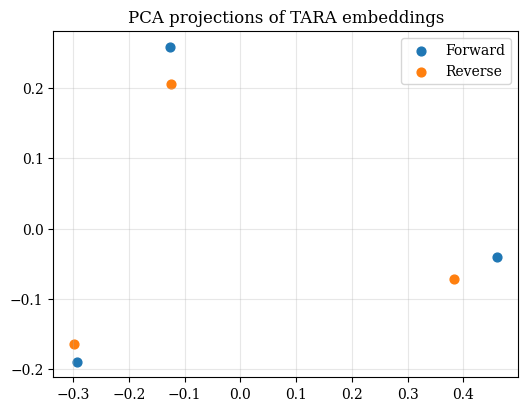

In [21]:
pca = su.visualize.reduce_dim(z, method='pca')

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
ax.scatter(pca[:len(fwd_files), 0], pca[:len(fwd_files), 1], s=40, label='Forward');
ax.scatter(pca[len(fwd_files):, 0], pca[len(fwd_files):, 1], s=40, label='Reverse');
ax.grid(alpha=0.3)
ax.legend()
ax.set_title("PCA projections of TARA embeddings")
plt.show()

### Caption matching

In [22]:
data = su.io.load_json(f"{meta_dir}/AoTBench_QA.json")
len(data)

1800

In [23]:
d = data[0]

video_path = f"{data_root}/{d['video_name']}"
prompt = d['question']

!du -sh $video_path

4.9M	/scratch/shared/beegfs/piyush/datasets/AoTBench/videos/nextqa/5918453123.mp4


In [24]:
video_tensor = read_frames_decord(video_path, num_frames=8)
with torch.no_grad():
    answer = generate_answer(
        prompt,
        video_tensor.unsqueeze(0),
        max_new_tokens=256,
    )
print(answer)

['B']


In [25]:
d['ans']

'B'

In [26]:
su.visualize.show_single_video(video_path)

In [27]:
# Just test on 100 random videos first
selected_data = np.random.choice(data, 100)
iterator = su.log.tqdm_iterator(selected_data, desc='Generating answers')
ground_truth = []
answers = []
for d in iterator:
    video_path = f"{data_root}/{d['video_name']}"
    prompt = d['question']

    try:
        video_tensor = read_frames_decord(video_path, num_frames=8)
        with torch.no_grad():
            answer = generate_answer(
                prompt,
                video_tensor.unsqueeze(0),
                max_new_tokens=256,
            )
        answers.append(answer)
        ground_truth.append(d['ans'])
    except:
        print(f"Failed {d['idx']}")
        continue
answers = np.array(answers)
ground_truth = np.array(ground_truth)
answers.shape, ground_truth.shape

Generating answers:   0%|          | 0/100 [00:00<?, ?it/s]

[buffer @ 0x1ad69680] Unable to parse option value "-1" as pixel format
[buffer @ 0x1ad69680] Unable to parse option value "-1" as pixel format
[buffer @ 0x1ad69680] Error setting option pix_fmt to value -1.
[in @ 0x43e3b4c0] Error applying options to the filter.


Failed 0645


[buffer @ 0x1952c200] Unable to parse option value "-1" as pixel format
[buffer @ 0x1952c200] Unable to parse option value "-1" as pixel format
[buffer @ 0x1952c200] Error setting option pix_fmt to value -1.
[in @ 0x4339a240] Error applying options to the filter.


Failed 0634


[buffer @ 0x432849c0] Unable to parse option value "-1" as pixel format
[buffer @ 0x432849c0] Unable to parse option value "-1" as pixel format
[buffer @ 0x432849c0] Error setting option pix_fmt to value -1.
[in @ 0x19e97980] Error applying options to the filter.


Failed 0609


((97, 1), (97,))

In [29]:
(answers[:, 0] == ground_truth).mean()

np.float64(0.4742268041237113)

### CameraBench

In [32]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/CameraBench"
video_dir = f"{data_dir}/videos_gif/"

data_path = f"{data_dir}/test.jsonl"
data = su.io.load_jsonl(data_path)
df = pd.DataFrame(data)
len(data)

1071

In [36]:
labels = np.unique(df.labels.sum())
len(labels)

34